In [ ]:
import numpy as np
import h5py
import os
import copy
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.0


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#model file path
model_file = "/content/drive/My Drive/ckids/tf-model-deep/models/model025.h5"

In [ ]:
#load the model
def load(model_file):
  assert os.path.exists(model_file), model_file + " does not exist."
  net = tf.keras.models.load_model(model_file)
  return net

In [ ]:
net = load(model_file)
#dot_img_file = "/content/drive/My Drive/ckids/tf-model-deep/models/model.png"
#tf.keras.utils.plot_model(net, to_file=dot_img_file, show_shapes=True, dpi = 50)

In [ ]:
#net.summary()

In [ ]:
#Get the weights of the model as a list
def get_weights(net):
    """ Extract parameters from net, and return a list of tensors"""
    return [weights for weights in net.get_weights()]

In [ ]:
w = get_weights(net)

In [ ]:
dir_file = 'ckid_loss_'

In [ ]:
#create a direction file to store random direction vector
def name_direction_file(model_file,ignore = 'biasbn', norm = 'filter'):
    """ Name the direction file that stores the random directions. """
    dir_file = ""
    # name for xdirection
    dir_file += model_file
    dir_file += '_' + 'weights'
    dir_file += '_xignore=' + str(ignore)
    dir_file += '_xnorm=' + str(norm)

    # name for ydirection
    dir_file += '_yignore=' + str(ignore)
    dir_file += '_ynorm=' + str(norm) # ydirection is the same as xdirection
    dir_file += '_same_dir'

    dir_file += ".h5"
    return dir_file

In [ ]:
dir_file = name_direction_file(model_file)

In [ ]:
def get_random_weights(weights):
    """
        Produce a random direction that is a list of random Gaussian tensors
        with the same shape as the network's weights, so one direction entry per weight.
    """
    return [np.random.normal(size = w.shape) for w in weights]


def normalize_directions_for_weights(direction, weights, norm='filter', ignore='biasbn'):
    """
        The normalization scales the direction entries according to the entries of weights.
    """
    assert(len(direction) == len(weights))
    for d, w in zip(direction, weights):
        if d.ndim <= 1:
            if ignore == 'biasbn':
                d.fill(0) # ignore directions for weights with 1 dimension
            else:
                d.copy_(w) # keep directions for weights/bias that are only 1 per node
        else:
            normalize_direction(d, w, norm)


def normalize_direction(direction, weights, norm='filter'):
    """
        Rescale the direction so that it has similar norm as their corresponding
        model in different levels.
        Args:
          direction: a variables of the random direction for one layer
          weights: a variable of the original model for one layer
          norm: normalization method, 'filter' | 'layer' | 'weight'
    """
    if norm == 'filter':
        # Rescale the filters (weights in group) in 'direction' so that each
        # filter has the same norm as its corresponding filter in 'weights'.
        for d, w in zip(direction, weights):
            d*=(np.linalg.norm(w)/(np.linalg.norm(d) + 1e-10))
    elif norm == 'layer':
        # Rescale the layer variables in the direction so that each layer has
        # the same norm as the layer variables in weights.
        direction.mul_(weights.norm()/direction.norm())
    elif norm == 'weight':
        # Rescale the entries in the direction so that each entry has the same
        # scale as the corresponding weight.
        direction.mul_(weights)
    elif norm == 'dfilter':
        # Rescale the entries in the direction so that each filter direction
        # has the unit norm.
        for d in direction:
            d.div_(d.norm() + 1e-10)
    elif norm == 'dlayer':
        # Rescale the entries in the direction so that each layer direction has
        # the unit norm.
        direction.div_(direction.norm())


def create_random_direction(net, dir_type='weights', ignore='biasbn', norm='filter'):
    """
        Setup a random (normalized) direction with the same dimension as
        the weights or states.
        Args:
          net: the given trained model
          dir_type: 'weights' or 'states', type of directions.
          ignore: 'biasbn', ignore biases and BN parameters.
          norm: direction normalization method, including
                'filter" | 'layer' | 'weight' | 'dlayer' | 'dfilter'
        Returns:
          direction: a random direction with the same dimension as weights or states.
    """

    # random direction
    weights = get_weights(net) # a list of parameters.
    direction = get_random_weights(weights)
    normalize_directions_for_weights(direction, weights, norm, ignore)
    #print(np.array(direction)[0].shape)
    return direction

def write_list(f, name, direction):
    """ Save the direction to the hdf5 file with name as the key
        Args:
            f: h5py file object
            name: key name_surface_file
            direction: a list of tensors
    """
    grp = f.create_group(name)
    for i, l in enumerate(direction):
        grp.create_dataset(str(i), data=l)

def read_list(f, name):
    """ Read group with name as the key from the hdf5 file and return a list numpy vectors. """
    grp = f[name]
    return [grp[str(i)] for i in range(len(grp))]

def setup_direction(dir_file,net):
    """
        Setup the h5 file to store the directions.
        - xdirection, ydirection: The pertubation direction added to the mdoel.
          The direction is a list of tensors.
    """
    print('-------------------------------------------------------------------')
    print('setup_direction')
    print('-------------------------------------------------------------------')
    
    # Create the plotting directions
    f = h5py.File(dir_file,'w') # create file, fail if exists
    print("Setting up the plotting directions...")
    xdirection = create_random_direction(net)
    write_list(f, 'xdirection', xdirection)
    ydirection = create_random_direction(net)
    write_list(f, 'ydirection', ydirection)

    f.close()
    print ("direction file created: %s" % dir_file)

In [ ]:
setup_direction(dir_file, net)

SURFACE FILE

In [ ]:
def name_surface_file(dir_file):
    # use args.dir_file as the perfix
    surf_file = dir_file

    # resolution
    surf_file += '_[%s,%s,%d]' % (str(-1), str(1), int(51))
    surf_file += 'x[%s,%s,%d]' % (str(-1), str(1), int(51))

    # dataloder parameters
    # if args.raw_data: # without data normalization
    #     surf_file += '_rawdata'
    # if args.data_split > 1:
    #     surf_file += '_datasplit=' + str(args.data_split) + '_splitidx=' + str(args.split_idx)
    surf_file += 'test2'
    return surf_file + ".h5"


def setup_surface_file(surf_file, dir_file):
    f = h5py.File(surf_file, 'a')
    f['dir_file'] = dir_file

    # Create the coordinates(resolutions) at which the function is evaluated
    xcoordinates = np.linspace(-1, 1, num=51)
    f['xcoordinates'] = xcoordinates
    ycoordinates = np.linspace(-1, 1, num=51)
    f['ycoordinates'] = ycoordinates
    f.close()

    return surf_file

In [ ]:
surf_file = name_surface_file(dir_file)
#surf_file = "/content/drive/My Drive/ckids/test_model/model_2/test1/model035.h5_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter_same_dir.h5_[-1,1,51]x[-1,1,51]test2.h5"
#setup_surface_file(surf_file, dir_file)

In [ ]:
def load_directions(dir_file):
    """ Load direction(s) from the direction file."""

    f = h5py.File(dir_file, 'r')
    if 'ydirection' in f.keys():  # If this is a 2D plot
        xdirection = read_list(f, 'xdirection')
        ydirection = read_list(f, 'ydirection')
        directions = [xdirection, ydirection]
    else:
        directions = [read_list(f, 'xdirection')]

    return directions

In [ ]:
d = load_directions(dir_file)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [ ]:
#(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [ ]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
#train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
from tqdm import tqdm
def get_job_indices(vals, xcoordinates, ycoordinates, comm):
    """
    Prepare the job indices over which coordinate to calculate.
    Args:
        vals: the value matrix
        xcoordinates: x locations, i.e.,[-1, -0.5, 0, 0.5, 1]
        ycoordinates: y locations, i.e.,[-1, -0.5, 0, 0.5, 1]
        comm: MPI environment
    Returns:
        inds: indices that splitted for current rank
        coords: coordinates for current rank
    """

    inds, coords = get_unplotted_indices(vals, xcoordinates, ycoordinates)

    return inds, coords

def get_unplotted_indices(vals, xcoordinates, ycoordinates=None):
    """
    Args:
      vals: values at (x, y), with value -1 when the value is not yet calculated.
      xcoordinates: x locations, i.e.,[-1, -0.5, 0, 0.5, 1]
      ycoordinates: y locations, i.e.,[-1, -0.5, 0, 0.5, 1]
    Returns:
      - a list of indices into vals for points that have not yet been calculated.
      - a list of corresponding coordinates, with one x/y coordinate per row.
    """

    # Create a list of indices into the vectorizes vals
    inds = np.array(range(vals.size))

    # Select the indices of the un-recorded entries, assuming un-recorded entries
    # will be smaller than zero. In case some vals (other than loss values) are
    # negative and those indexces will be selected again and calcualted over and over.
    inds = inds[vals.ravel() <= 0]

    # Make lists containing the x- and y-coodinates of the points to be plotted
    if ycoordinates is not None:
        # If the plot is 2D, then use meshgrid to enumerate all coordinates in the 2D mesh
        xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
        s1 = xcoord_mesh.ravel()[inds]
        s2 = ycoord_mesh.ravel()[inds]
        return inds, np.c_[s1,s2]
    else:
        return inds, xcoordinates.ravel()[inds]

def arr_dimen(a):
  return [len(a)]+arr_dimen(a[0]) if(type(a) == list) else []

def set_weights(net, weights, directions=None, step=None):
    """
        Overwrite the network's weights with a specified list of tensors
        or change weights along directions with a step size.
    """

    assert step is not None, 'If a direction is specified then step must be specified as well'
    dx = directions[0]
    dy = directions[1]
    changes = [d0*step[0] + d1*step[1] for (d0, d1) in zip(dx, dy)]
    idx = 0
    for layer in net.layers:
      if layer.get_weights:
        w = []
        changes_idx = 0
        for ori in layer.get_weights():
          w.append(np.array(weights[idx]) + np.array(changes[idx]))
          idx+=1
        layer.set_weights(w)

        
def eval_loss(net,use_cuda=False):
#     """
#     Evaluate the loss value for a given 'net' on the dataset provided by the loader.
#     Args:
#         net: the neural net model
#         criterion: loss function
#         loader: dataloader
#         use_cuda: use cuda or not
#     Returns:
#         loss value and accuracy
#     """
    correct = 0
    total_loss = 0
    total = 0 # number of samples
    #print("Calculating Loss...")
    loss,acc = net.evaluate(train_images, train_labels,verbose=0,batch_size=32)
    
    return loss, 100.*acc
          
def crunch(surf_file, net, w, s, d, dataloader, loss_key, acc_key, comm, rank):
    """
        Calculate the loss values and accuracies of modified models in parallel
        using MPI reduce.
    """

    f = h5py.File(surf_file, 'r+')
    losses, accuracies = [], []
    xcoordinates = f['xcoordinates'][:]
    ycoordinates = f['ycoordinates'][:] if 'ycoordinates' in f.keys() else None

    if loss_key not in f.keys():
        shape = xcoordinates.shape if ycoordinates is None else (len(xcoordinates),len(ycoordinates))
        losses = -np.ones(shape=shape)
        accuracies = -np.ones(shape=shape)
        if rank == 0:
            f[loss_key] = losses
            f[acc_key] = accuracies
    else:
        losses = f[loss_key][:]
        accuracies = f[acc_key][:]

    # Generate a list of indices of 'losses' that need to be filled in.
    # The coordinates of each unfilled index (with respect to the direction vectors
    # stored in 'd') are stored in 'coords'.
    inds, coords = get_job_indices(losses, xcoordinates, ycoordinates, None)
    print('Computing %d values for rank %d'% (len(inds), rank))
    start_time = time.time()
    total_sync = 0.0

    # # Loop over all uncalculated loss values
    for count, ind in enumerate(inds):
        # Get the coordinates of the loss value being calculated
        coord = coords[count]
        #Load the weights corresponding to those coordinates into the net
        set_weights(net, w, d, coord)
    # #     # Record the time to compute the loss value
        loss_start = time.time()
        loss, acc = eval_loss(net)
        loss_compute_time = time.time() - loss_start

    # #     # Record the result in the local array
        losses.ravel()[ind] = loss
        accuracies.ravel()[ind] = acc
        if rank == 0:
          f[loss_key][:] = losses
          f[acc_key][:] = accuracies
          f.flush()
        #plot_2d_contour(surf_file,'train_loss')
        
        print('Evaluating rank %d  %d/%d  (%.1f%%)  coord=%s \t%s= %.3f \t%s=%.2f \ttime=%.2f' % (
                rank, count, len(inds), 100.0 * count/len(inds), str(coord), loss_key, loss,
                acc_key, acc, loss_compute_time))

    total_time = time.time() - start_time
    print('Rank %d done!  Total time: %.2f Sync: %.2f' % (rank, total_time, total_sync))

    f.close()

In [ ]:
crunch(surf_file, net, w, _, d, None, 'train_loss', 'train_acc', comm = None,rank = 0)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
def plot_2d_contour(surf_file, surf_name='train_loss', vmin=0.1, vmax=50, vlevel=0.5, show=False):
    """Plot 2D contour map and 3D surface."""

    f = h5py.File(surf_file, 'r')
    x = np.array(f['xcoordinates'][:])
    y = np.array(f['ycoordinates'][:])
    X, Y = np.meshgrid(x, y)
    print(f.keys())
    if surf_name in f.keys():
        Z = np.array(f[surf_name][:]) 
        print('max(%s) = %f \t min(%s) = %f' % (surf_name, np.max(Z), surf_name, np.min(Z)))
        print(Z.shape)
        for i in range(Z.shape[0]):
          for j in range(Z.shape[1]):
            if(Z[i][j] > 20):
              Z[i][j] = 20
    elif surf_name == 'train_err' or surf_name == 'test_err' :
        Z = 100 - np.array(f[surf_name][:])
    else:
        print ('%s is not found in %s' % (surf_name, surf_file))

    print('------------------------------------------------------------------')
    print('plot_2d_contour')
    print('------------------------------------------------------------------')
    print("loading surface file: " + surf_file)
    print('len(xcoordinates): %d   len(ycoordinates): %d' % (len(x), len(y)))
    print('max(%s) = %f \t min(%s) = %f' % (surf_name, np.max(Z), surf_name, np.min(Z)))
    idx = np.unravel_index(Z.argmin(), Z.shape)
    print("Coordinates at Lowest Loss: (",x[idx[0]],',',y[idx[1]],')')
    #print(Z)

    if (len(x) <= 1 or len(y) <= 1):
        print('The length of coordinates is not enough for plotting contours')
        return

    # --------------------------------------------------------------------
    # Plot 2D contours
    # --------------------------------------------------------------------
    fig = plt.figure()
    CS = plt.contour(X, Y, Z, cmap='summer',levels=np.arange(vmin, vmax, vlevel))
    plt.clabel(CS, inline=1, fontsize=8)
    fig.savefig(surf_file + '_' + surf_name + '_2dcontour' + '.pdf', dpi=300,
                bbox_inches='tight', format='pdf')

    fig = plt.figure()
    print(surf_file + '_' + surf_name + '_2dcontourf' + '.pdf')
    CS = plt.contourf(X, Y, Z, cmap='summer', levels=np.arange(vmin, vmax, vlevel))
    fig.savefig(surf_file + '_' + surf_name + '_2dcontourf' + '.pdf', dpi=300,
                bbox_inches='tight', format='pdf')
    plt.show()
    # --------------------------------------------------------------------
    # Plot 2D heatmaps
    # --------------------------------------------------------------------
    fig = plt.figure()
    sns_plot = sns.heatmap(Z, cmap='viridis', cbar=True, vmin=vmin, vmax=vmax,
                           xticklabels=False, yticklabels=False)
    sns_plot.invert_yaxis()
    sns_plot.get_figure().savefig(surf_file + '_' + surf_name + '_2dheat.pdf',
                                   dpi=300, bbox_inches='tight', format='pdf')
    plt.show()
    # --------------------------------------------------------------------
    # Plot 3D surface
    # --------------------------------------------------------------------
    fig = plt.figure()
    ax = Axes3D(fig)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_zlim3d(0,20)
    ticks=np.arange(0,21,2.5)
    #fig.colorbar(surf, shrink=0.5, aspect=5, ticks = list(ticks))
    #ticks=np.arange(0,21,2.5)
    fig.colorbar(surf,ticks = list(ticks))
    fig.savefig(surf_file + '_' + surf_name + '_3dsurface.pdf', dpi=300,
                bbox_inches='tight', format='pdf')

    f.close()

<KeysViewHDF5 ['dir_file', 'train_acc', 'train_loss', 'xcoordinates', 'ycoordinates']>
max(train_loss) = 522.845642 	 min(train_loss) = 0.166153
(51, 51)
------------------------------------------------------------------
plot_2d_contour
------------------------------------------------------------------
loading surface file: /content/drive/My Drive/ckids/tf-model-deep/models/model025.h5_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter_same_dir.h5_[-1,1,51]x[-1,1,51]test2.h5
len(xcoordinates): 51   len(ycoordinates): 51
max(train_loss) = 20.000000 	 min(train_loss) = 0.166153
Coordinates at Lowest Loss: ( 0.0 , 0.0 )
/content/drive/My Drive/ckids/tf-model-deep/models/model025.h5_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter_same_dir.h5_[-1,1,51]x[-1,1,51]test2.h5_train_loss_2dcontourf.pdf


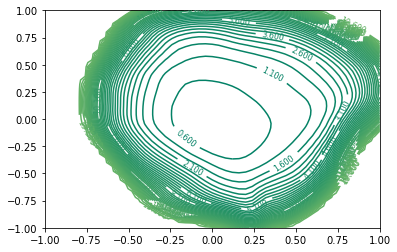

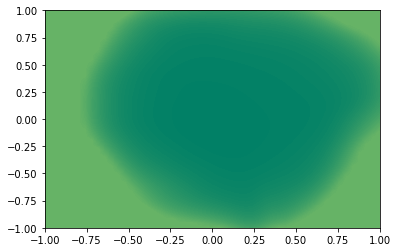

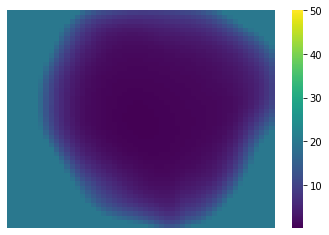

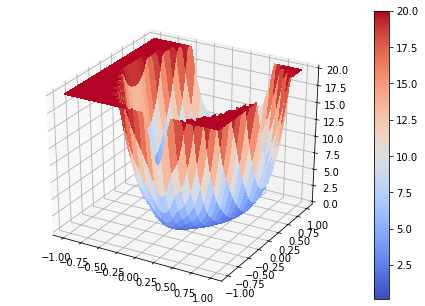

In [ ]:
plot_2d_contour(surf_file,'train_loss')
# plot_2d_contour(surf_file,'train_acc')

In [ ]:
h5_to_vtp(surf_file, surf_name='train_loss', log=False, zmax=-1, interp=-1)

In [ ]:
import math
import argparse
import h5py
import numpy as np
from scipy import interpolate

def h5_to_vtp(surf_file, surf_name='train_loss', log=False, zmax=-1, interp=-1):
    #set this to True to generate points
    show_points = False
    #set this to True to generate polygons
    show_polys = True

    f = h5py.File(surf_file,'r')

    [xcoordinates, ycoordinates] = np.meshgrid(f['xcoordinates'][:], f['ycoordinates'][:][:])
    vals = f[surf_name]

    x_array = xcoordinates[:].ravel()
    y_array = ycoordinates[:].ravel()
    z_array = vals[:].ravel()
    print(z_array.shape)

    for i in range(z_array.shape[0]):
      if z_array[i] > 20:
        z_array[i] = 20
    # Interpolate the resolution up to the desired amount
    if interp > 0:
        m = interpolate.interp2d(xcoordinates[0,:], ycoordinates[:,0], vals, kind='cubic')
        x_array = np.linspace(min(x_array), max(x_array), interp)
        y_array = np.linspace(min(y_array), max(y_array), interp)
        z_array = m(x_array, y_array).ravel()

        x_array, y_array = np.meshgrid(x_array, y_array)
        x_array = x_array.ravel()
        y_array = y_array.ravel()

    vtp_file = surf_file + "_" + surf_name
    if zmax > 0:
        z_array[z_array > zmax] = zmax
        vtp_file +=  "_zmax=" + str(zmax)

    if log:
        z_array = np.log(z_array + 0.1)
        vtp_file +=  "_log"
    vtp_file +=  ".vtp"
    print("Here's your output file:{}".format(vtp_file))

    number_points = len(z_array)
    print("number_points = {} points".format(number_points))

    matrix_size = int(math.sqrt(number_points))
    print("matrix_size = {} x {}".format(matrix_size, matrix_size))

    poly_size = matrix_size - 1
    print("poly_size = {} x {}".format(poly_size, poly_size))

    number_polys = poly_size * poly_size
    print("number_polys = {}".format(number_polys))

    min_value_array = [min(x_array), min(y_array), min(z_array)]
    max_value_array = [max(x_array), max(y_array), max(z_array)]
    min_value = min(min_value_array)
    max_value = max(max_value_array)

    averaged_z_value_array = []

    poly_count = 0
    for column_count in range(poly_size):
        stride_value = column_count * matrix_size
        for row_count in range(poly_size):
            temp_index = stride_value + row_count
            averaged_z_value = (z_array[temp_index] + z_array[temp_index + 1] +
                                z_array[temp_index + matrix_size]  +
                                z_array[temp_index + matrix_size + 1]) / 4.0
            averaged_z_value_array.append(averaged_z_value)
            poly_count += 1

    avg_min_value = min(averaged_z_value_array)
    avg_max_value = max(averaged_z_value_array)

    output_file = open(vtp_file, 'w')
    output_file.write('<VTKFile type="PolyData" version="1.0" byte_order="LittleEndian" header_type="UInt64">\n')
    output_file.write('  <PolyData>\n')

    if (show_points and show_polys):
        output_file.write('    <Piece NumberOfPoints="{}" NumberOfVerts="{}" NumberOfLines="0" NumberOfStrips="0" NumberOfPolys="{}">\n'.format(number_points, number_points, number_polys))
    elif (show_polys):
        output_file.write('    <Piece NumberOfPoints="{}" NumberOfVerts="0" NumberOfLines="0" NumberOfStrips="0" NumberOfPolys="{}">\n'.format(number_points, number_polys))
    else:
        output_file.write('    <Piece NumberOfPoints="{}" NumberOfVerts="{}" NumberOfLines="0" NumberOfStrips="0" NumberOfPolys="">\n'.format(number_points, number_points))

    # <PointData>
    output_file.write('      <PointData>\n')
    output_file.write('        <DataArray type="Float32" Name="zvalue" NumberOfComponents="1" format="ascii" RangeMin="{}" RangeMax="{}">\n'.format(min_value_array[2], max_value_array[2]))
    for vertexcount in range(number_points):
        if (vertexcount % 6) is 0:
            output_file.write('          ')
        output_file.write('{}'.format(z_array[vertexcount]))
        if (vertexcount % 6) is 5:
            output_file.write('\n')
        else:
            output_file.write(' ')
    if (vertexcount % 6) is not 5:
        output_file.write('\n')
    output_file.write('        </DataArray>\n')
    output_file.write('      </PointData>\n')

    # <CellData>
    output_file.write('      <CellData>\n')
    if (show_polys and not show_points):
        output_file.write('        <DataArray type="Float32" Name="averaged zvalue" NumberOfComponents="1" format="ascii" RangeMin="{}" RangeMax="{}">\n'.format(avg_min_value, avg_max_value))
        for vertexcount in range(number_polys):
            if (vertexcount % 6) is 0:
                output_file.write('          ')
            output_file.write('{}'.format(averaged_z_value_array[vertexcount]))
            if (vertexcount % 6) is 5:
                output_file.write('\n')
            else:
                output_file.write(' ')
        if (vertexcount % 6) is not 5:
            output_file.write('\n')
        output_file.write('        </DataArray>\n')
    output_file.write('      </CellData>\n')

    # <Points>
    output_file.write('      <Points>\n')
    output_file.write('        <DataArray type="Float32" Name="Points" NumberOfComponents="3" format="ascii" RangeMin="{}" RangeMax="{}">\n'.format(min_value, max_value))
    for vertexcount in range(number_points):
        if (vertexcount % 2) is 0:
            output_file.write('          ')
        output_file.write('{} {} {}'.format(x_array[vertexcount], y_array[vertexcount], z_array[vertexcount]))
        if (vertexcount % 2) is 1:
            output_file.write('\n')
        else:
            output_file.write(' ')
    if (vertexcount % 2) is not 1:
        output_file.write('\n')
    output_file.write('        </DataArray>\n')
    output_file.write('      </Points>\n')

    # <Verts>
    output_file.write('      <Verts>\n')
    output_file.write('        <DataArray type="Int64" Name="connectivity" format="ascii" RangeMin="0" RangeMax="{}">\n'.format(number_points - 1))
    if (show_points):
        for vertexcount in range(number_points):
            if (vertexcount % 6) is 0:
                output_file.write('          ')
            output_file.write('{}'.format(vertexcount))
            if (vertexcount % 6) is 5:
                output_file.write('\n')
            else:
                output_file.write(' ')
        if (vertexcount % 6) is not 5:
            output_file.write('\n')
    output_file.write('        </DataArray>\n')
    output_file.write('        <DataArray type="Int64" Name="offsets" format="ascii" RangeMin="1" RangeMax="{}">\n'.format(number_points))
    if (show_points):
        for vertexcount in range(number_points):
            if (vertexcount % 6) is 0:
                output_file.write('          ')
            output_file.write('{}'.format(vertexcount + 1))
            if (vertexcount % 6) is 5:
                output_file.write('\n')
            else:
                output_file.write(' ')
        if (vertexcount % 6) is not 5:
            output_file.write('\n')
    output_file.write('        </DataArray>\n')
    output_file.write('      </Verts>\n')

    # <Lines>
    output_file.write('      <Lines>\n')
    output_file.write('        <DataArray type="Int64" Name="connectivity" format="ascii" RangeMin="0" RangeMax="{}">\n'.format(number_polys - 1))
    output_file.write('        </DataArray>\n')
    output_file.write('        <DataArray type="Int64" Name="offsets" format="ascii" RangeMin="1" RangeMax="{}">\n'.format(number_polys))
    output_file.write('        </DataArray>\n')
    output_file.write('      </Lines>\n')

    # <Strips>
    output_file.write('      <Strips>\n')
    output_file.write('        <DataArray type="Int64" Name="connectivity" format="ascii" RangeMin="0" RangeMax="{}">\n'.format(number_polys - 1))
    output_file.write('        </DataArray>\n')
    output_file.write('        <DataArray type="Int64" Name="offsets" format="ascii" RangeMin="1" RangeMax="{}">\n'.format(number_polys))
    output_file.write('        </DataArray>\n')
    output_file.write('      </Strips>\n')

    # <Polys>
    output_file.write('      <Polys>\n')
    output_file.write('        <DataArray type="Int64" Name="connectivity" format="ascii" RangeMin="0" RangeMax="{}">\n'.format(number_polys - 1))
    if (show_polys):
        polycount = 0
        for column_count in range(poly_size):
            stride_value = column_count * matrix_size
            for row_count in range(poly_size):
                temp_index = stride_value + row_count
                if (polycount % 2) is 0:
                    output_file.write('          ')
                output_file.write('{} {} {} {}'.format(temp_index, (temp_index + 1), (temp_index + matrix_size + 1), (temp_index + matrix_size)))
                if (polycount % 2) is 1:
                    output_file.write('\n')
                else:
                    output_file.write(' ')
                polycount += 1
        if (polycount % 2) is 1:
            output_file.write('\n')
    output_file.write('        </DataArray>\n')
    output_file.write('        <DataArray type="Int64" Name="offsets" format="ascii" RangeMin="1" RangeMax="{}">\n'.format(number_polys))
    if (show_polys):
        for polycount in range(number_polys):
            if (polycount % 6) is 0:
                output_file.write('          ')
            output_file.write('{}'.format((polycount + 1) * 4))
            if (polycount % 6) is 5:
                output_file.write('\n')
            else:
                output_file.write(' ')
        if (polycount % 6) is not 5:
            output_file.write('\n')
    output_file.write('        </DataArray>\n')
    output_file.write('      </Polys>\n')

    output_file.write('    </Piece>\n')
    output_file.write('  </PolyData>\n')
    output_file.write('</VTKFile>\n')
    output_file.write('')
    output_file.close()

    print("Done with file:{}".format(vtp_file))